In [1]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
from datetime import datetime
from PIL import Image
import seaborn as sns
import shutil
import re
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime
from PIL import Image
from tqdm import tqdm
from skimage import color, io
from PIL import Image

# Increase the maximum allowed image pixels
Image.MAX_IMAGE_PIXELS = None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


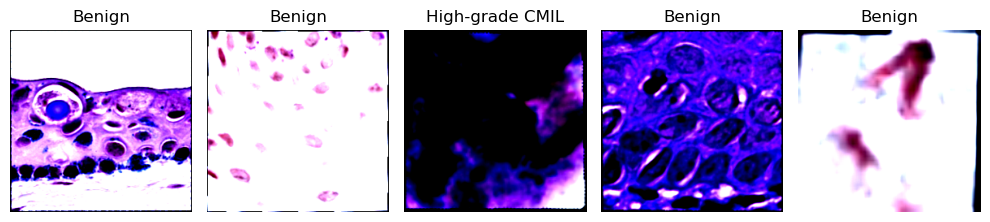

In [2]:
# Select only specified cases
benign_cases = [2, 21, 22, 25, 34, 45, 53, 77, 78, 79, 85, 90]
high_grade_cases = [1, 3, 9, 12, 38, 49, 55, 60, 62, 70, 89, 92, 98, 99]
selected_cases = benign_cases + high_grade_cases

# Load and clean labels
labels = pd.read_csv('/Users/harveywang/Downloads/case_grade_match.csv')
labels = labels.drop(index=64, errors='ignore').reset_index(drop=True)

# Group patches by case number
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)
        if match:
            case_num = int(match.group(1))
            if case_num in selected_cases:
                case_patches.setdefault(case_num, []).append(os.path.join(patch_dir, filename))
    return case_patches

# Dataset class
class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.case_patches = case_patches
        self.labels_df = labels_df
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for case_num, patches in case_patches.items():
            label_row = labels_df[labels_df['Case'] == case_num]
            if not label_row.empty:
                label = label_row['Class'].values[0]
                if label == 1:  # Benign
                    binary_label = 0
                elif label == 3:  # High-grade
                    binary_label = 1
                else:
                    continue  # Skip low-grade or unknown
                for patch_path in patches:
                    self.image_paths.append(patch_path)
                    self.labels.append(binary_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load filtered patches
image_folder_path = '/Users/harveywang/Library/CloudStorage/GoogleDrive-harveywang2026@u.northwestern.edu/My Drive/Northwestern/Coursework/2025 Spring/STAT 390/CMIL_SP2025_Patches_Apr16'
patches = group_patches(image_folder_path)

# Filter labels
filtered_labels = labels[labels['Case'].isin(selected_cases)].reset_index(drop=True)

# Prepare binary label column for stratified split
filtered_labels = filtered_labels[filtered_labels['Class'].isin([1.0, 3.0])]
filtered_labels['BinaryClass'] = filtered_labels['Class'].map({1.0: 0, 3.0: 1})

X = filtered_labels['Case']
y = filtered_labels['BinaryClass']

# Stratified split
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

# Match patch files
train_patches = {int(case): patches[int(case)] for case in train_X if int(case) in patches}
val_patches = {int(case): patches[int(case)] for case in val_X if int(case) in patches}
test_patches = {int(case): patches[int(case)] for case in test_X if int(case) in patches}

# Create datasets and loaders
train_dataset = PNGDataset(train_patches, filtered_labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, filtered_labels, transform=eval_transform)
test_dataset = PNGDataset(test_patches, filtered_labels, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualize sample images
images, labels_batch = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title('Benign' if labels_batch[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [3]:
def get_predictions(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction_ratio, channels, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()

        self.conv_spatial = nn.Conv2d(2, 1, kernel_size, stride=1, padding=kernel_size // 2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.shared_mlp(self.avg_pool(x).view(b, c))
        max_out = self.shared_mlp(self.max_pool(x).view(b, c))
        channel_att = self.sigmoid_channel(avg_out + max_out).view(b, c, 1, 1)
        x = x * channel_att

        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = self.sigmoid_spatial(self.conv_spatial(torch.cat([avg_out, max_out], dim=1)))
        x = x * spatial_att
        return x

# EfficientNetB3 + CBAM
class EfficientNetB3_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNetB3_CBAM, self).__init__()
        base_model = models.efficientnet_b3(weights='IMAGENET1K_V1')
        self.features = base_model.features
        self.cbam = CBAM(channels=1536)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# Instantiate the model and load weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetB3_CBAM(num_classes=2).to(device)

# Load weights
model.load_state_dict(torch.load('/Users/harveywang/models_5_4/best_model.pth', map_location=device))
model.eval()  # Set to eval mode before inference or evaluation

EfficientNetB3_CBAM(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNo

In [6]:
# Get true and predicted labels
true_labels, pred_labels = get_predictions(model, val_loader)  # or val_loader

# If binary classification, use average='binary'; for multiclass use 'macro' or 'weighted'
precision = precision_score(true_labels, pred_labels, average='binary')
recall = recall_score(true_labels, pred_labels, average='binary')
f1 = f1_score(true_labels, pred_labels, average='binary')
accuracy = accuracy_score(true_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.8713
Precision: 0.4470
Recall:    0.3986
F1 Score:  0.4214


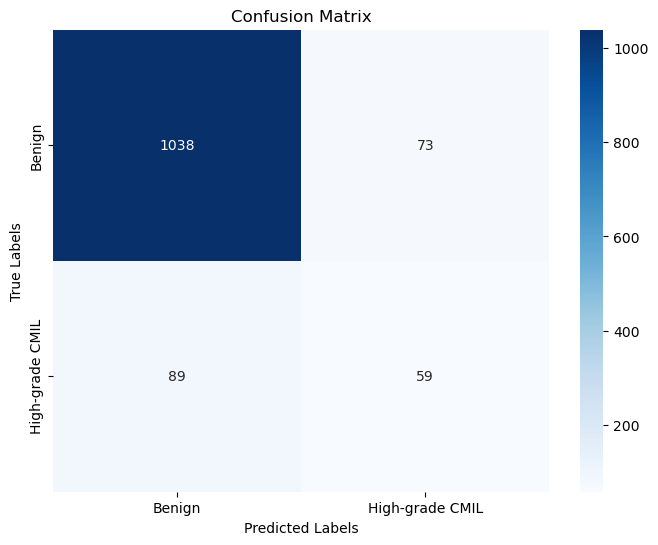

In [7]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [8]:
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Benign', 'Malignant']))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.93      0.93      1111
   Malignant       0.45      0.40      0.42       148

    accuracy                           0.87      1259
   macro avg       0.68      0.67      0.67      1259
weighted avg       0.87      0.87      0.87      1259

